# Modeling and Evaluation

In [1]:
### ALL THE IMPORTS NEEDED FOR THIS PHASE

# Data wrangling
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Cross-validation
from sklearn.model_selection import GridSearchCV

# Understanding the results of an evaluation
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv", header=None)
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv", header=None)

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16318 entries, 0 to 16317
Data columns (total 8 columns):
age                    16318 non-null float64
new_user               16318 non-null int64
total_pages_visited    16318 non-null float64
country_Germany        16318 non-null int64
country_UK             16318 non-null int64
country_US             16318 non-null int64
source_Direct          16318 non-null int64
source_Seo             16318 non-null int64
dtypes: float64(2), int64(6)
memory usage: 1020.0 KB


In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16318, 8), (4080, 8), (16318, 1), (4080, 1))

In [5]:
X_train.head()

,age,new_user,total_pages_visited,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,-0.204283,0,-0.588531,0,0,0,0,1
1,0.176354,1,-0.918939,0,1,0,0,1
2,1.191385,1,-0.753735,0,0,1,0,1
3,-1.346193,0,-0.092918,0,0,1,1,0
4,0.303233,0,0.898306,0,1,0,0,1


## Classification algorithms

* We recall that we are in a supervised learning problem where we seek to predict the outputs of a dichotomous variable, namely __converted__.
* For the continuation, we will call class 0 of variable __converted__ the negative class, and class 1 will be referred to as the positive class. 

### Logistic Regression

In [6]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [7]:
print("Logistic Regression score on training set :", log_reg.score(X_train, y_train))
print("Logistic Regression score on test set :", log_reg.score(X_test, y_test))

Logistic Regression score on training set : 0.9404951587204314
Logistic Regression score on test set : 0.9387254901960784


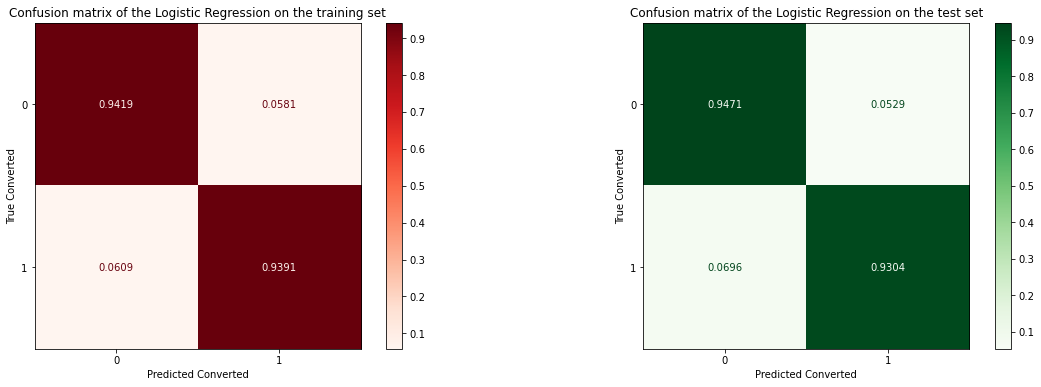

In [8]:
fig, axs = plt.subplots(figsize=(20,6), nrows=1, ncols=2)
plot_confusion_matrix(log_reg, X_train, y_train, ax=axs[0], normalize='true', values_format='.4f', cmap=plt.cm.Reds)
axs[0].set_title("Confusion matrix of the Logistic Regression on the training set")
axs[0].set_xlabel("Predicted Converted")
axs[0].set_ylabel("True Converted")

plot_confusion_matrix(log_reg, X_test, y_test, ax=axs[1], normalize='true', values_format='.4f', cmap=plt.cm.Greens)
axs[1].set_title("Confusion matrix of the Logistic Regression on the test set")
axs[1].set_xlabel("Predicted Converted")
axs[1].set_ylabel("True Converted")
plt.show()

* On training set, our logistic regression model recognizes 94.19% of individuals from the negative class and 93.91% from the positive class.
* On test set, the model predicts the right class of membership for 94.71% of individuals from the negative class and 93.04% of users from the positive class.

In [10]:
print("Classification metrics on training set")
print(classification_report(y_train, log_reg.predict(X_train)))
print()
print("Classification metrics on test set")
print(classification_report(y_test, log_reg.predict(X_test)))

Classification metrics on training set
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8160
           1       0.94      0.94      0.94      8158

    accuracy                           0.94     16318
   macro avg       0.94      0.94      0.94     16318
weighted avg       0.94      0.94      0.94     16318


Classification metrics on test set
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2040
           1       0.95      0.93      0.94      2040

    accuracy                           0.94      4080
   macro avg       0.94      0.94      0.94      4080
weighted avg       0.94      0.94      0.94      4080



* We effectively get good results : the positive class f1-score is 0.94 on training set and 0.94 on test set.
* More specifically, on our test set, the model is performing 93% correct predictions on positive class, and 95% for the individuals from the negative class.

In [11]:
coefficient_ranking = pd.DataFrame(
    data=log_reg.coef_.reshape(-1, 1),
    index=X_train.columns, 
    columns=["Coefficient"])
coefficient_ranking

,Coefficient
age,-0.521981
new_user,-1.581639
total_pages_visited,4.466979
country_Germany,3.605528
country_UK,3.505579
country_US,3.165444
source_Direct,-0.087256
source_Seo,0.086509


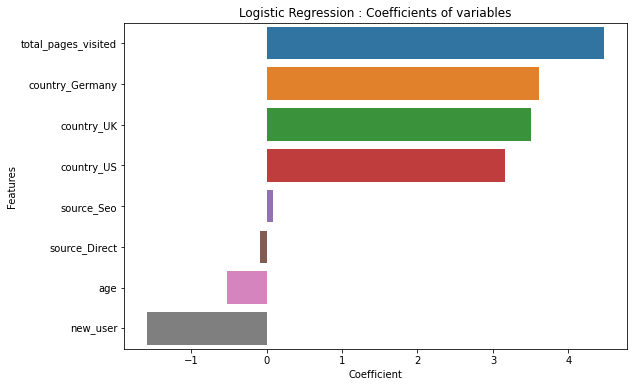

In [12]:
coefficient_ranking = coefficient_ranking.sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(9,6))
sns.barplot(data=coefficient_ranking, x="Coefficient", y=coefficient_ranking.index)
plt.ylabel("Features")
plt.title("Logistic Regression : Coefficients of variables")
plt.show()

* Unsurprisingly, the highest coefficient is that of the variable corresponding to the number of pages visited.
* The variable __new_user__ plays a role in the conversion of an individual (coefficient greater than 1 in absolute value).
* However, we did not anticipate the great influence of the country of connexion in the purchase decision : the coefficients of the three countries (Germany, UK, USA) are greater than 3.

### Decision Tree

In [13]:
tree_classifier = DecisionTreeClassifier(max_depth=5)
tree_classifier.fit(X_train, y_train)
tree_classifier.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [14]:
print("Tree Decision score on training set :", tree_classifier.score(X_train, y_train))
print("Tree Decision score on test set :", tree_classifier.score(X_test, y_test))

Tree Decision score on training set : 0.9307513175634269
Tree Decision score on test set : 0.9316176470588236


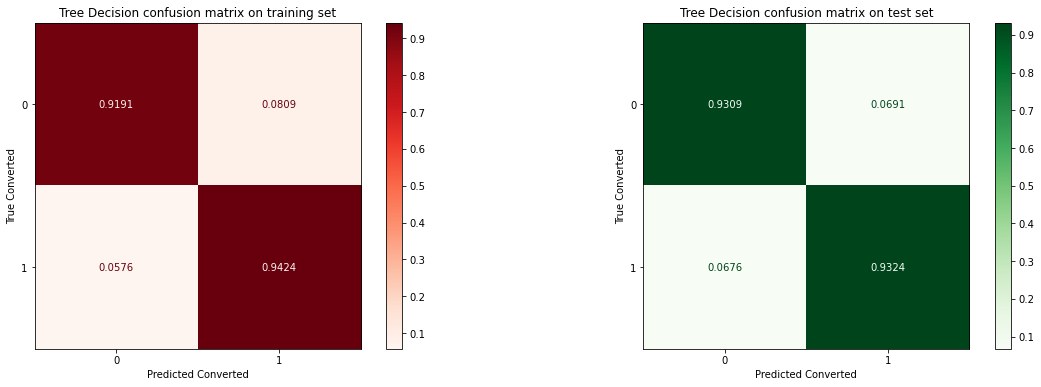

In [15]:
fig, axs = plt.subplots(figsize=(20,6), nrows=1, ncols=2)
plot_confusion_matrix(tree_classifier, X_train, y_train, ax=axs[0], normalize='true', values_format='.4f', cmap=plt.cm.Reds)
axs[0].set_title("Tree Decision confusion matrix on training set")
axs[0].set_xlabel("Predicted Converted")
axs[0].set_ylabel("True Converted")

plot_confusion_matrix(tree_classifier, X_test, y_test, ax=axs[1], normalize='true', values_format='.4f', cmap=plt.cm.Greens)
axs[1].set_title("Tree Decision confusion matrix on test set")
axs[1].set_xlabel("Predicted Converted")
axs[1].set_ylabel("True Converted")
plt.show()

* On training set, our tree decision model predicts the right class for 91.91% of individuals from the negative class and 94.24% of samples from the positive class.
* On test set, the model correctly identifies 93.09% of individuals in the negative class ans 93.24% oh users in the positive class.

In [16]:
print("Tree Decision : classification metrics on training set")
print(classification_report(y_train, tree_classifier.predict(X_train)))
print()
print("Tree Decision : classification metrics on test set")
print(classification_report(y_test, tree_classifier.predict(X_test)))

Tree Decision : classification metrics on training set
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      8160
           1       0.92      0.94      0.93      8158

    accuracy                           0.93     16318
   macro avg       0.93      0.93      0.93     16318
weighted avg       0.93      0.93      0.93     16318


Tree Decision : classification metrics on test set
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2040
           1       0.93      0.93      0.93      2040

    accuracy                           0.93      4080
   macro avg       0.93      0.93      0.93      4080
weighted avg       0.93      0.93      0.93      4080



* We achieve as good results as with the logistic regression model : the positive class f1-score and the negative class f1-score are the same (0.93) for the two classes, no matter if it concerns the training set or the test set. 

In [17]:
feature_importance = pd.DataFrame(
    data=tree_classifier.feature_importances_.reshape(-1, 1),
    index=X_train.columns, 
    columns=["Score"])
feature_importance

,Score
age,0.009157
new_user,0.028702
total_pages_visited,0.960713
country_Germany,0.000000
country_UK,0.001213
country_US,0.000214
source_Direct,0.000000
source_Seo,0.000000


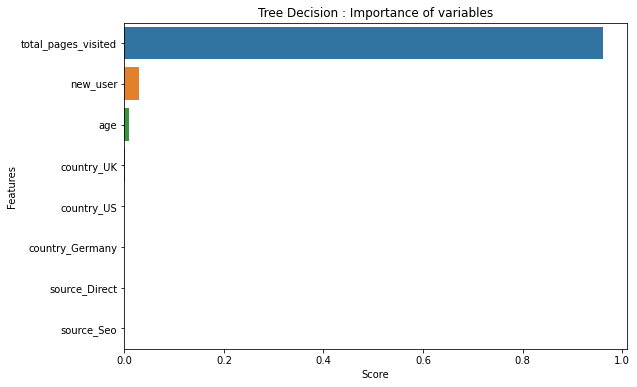

In [18]:
feature_importance = feature_importance.sort_values(by="Score", ascending=False)

plt.figure(figsize=(9,6))
sns.barplot(data=feature_importance, x="Score", y=feature_importance.index)
plt.ylabel("Features")
plt.title("Tree Decision : Importance of variables")
plt.show()

* The score of the variable __total_pages_visited__ is much higher than the scores of the other variables. That confirms the preponderant role of this feature, this is what we noticed earlier with the logistic regression. 

### Random Forest

Let us analyse the results obtained after applying a random forest composed of 50 decisions trees.

In [19]:
rand_forest = RandomForestClassifier(n_estimators=50, max_depth=5)
rand_forest.fit(X_train, y_train)
rand_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [20]:
print("Random forest score on training set :", rand_forest.score(X_train, y_train))
print("Random forest score on test set :", rand_forest.score(X_test, y_test))

Random forest score on training set : 0.9335702904767741
Random forest score on test set : 0.9306372549019608


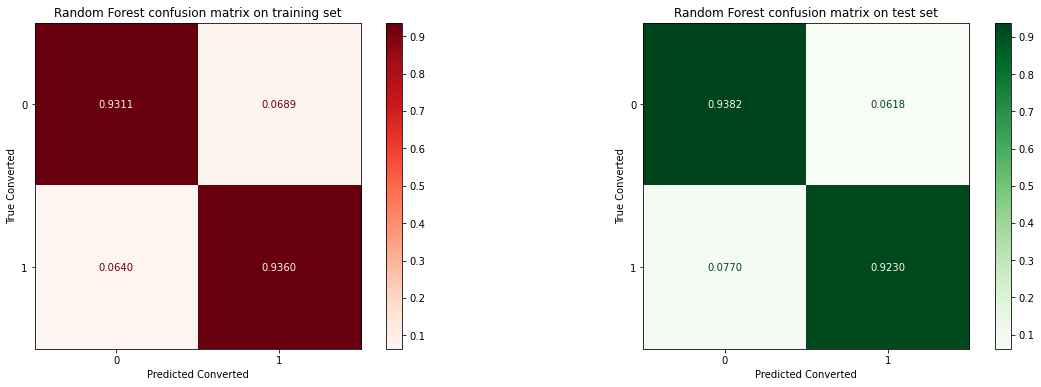

In [21]:
fig, axs = plt.subplots(figsize=(20,6), nrows=1, ncols=2)

plot_confusion_matrix(rand_forest, X_train, y_train, ax=axs[0], normalize='true', values_format='.4f', cmap=plt.cm.Reds)
axs[0].set_title("Random Forest confusion matrix on training set")
axs[0].set_xlabel("Predicted Converted")
axs[0].set_ylabel("True Converted")

plot_confusion_matrix(rand_forest, X_test, y_test, ax=axs[1], normalize='true', values_format='.4f', cmap=plt.cm.Greens)
axs[1].set_title("Random Forest confusion matrix on test set")
axs[1].set_xlabel("Predicted Converted")
axs[1].set_ylabel("True Converted")

plt.show()

* On training set, our random forest model predicts the right class for 93.11% of individuals from the negative class and 93.6% of users in the positive class.
* On test set, the model correctly identifies 93.82% of individuals in the negative class, and 92.3% of users from the positive class.

In [22]:
print("Random forest : classification metrics on training set")
print(classification_report(y_true=y_train, y_pred=rand_forest.predict(X_train)))
print()
print("Random forest : classification metrics on test set")
print(classification_report(y_true=y_test, y_pred=rand_forest.predict(X_test)))

Random forest : classification metrics on training set
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      8160
           1       0.93      0.94      0.93      8158

    accuracy                           0.93     16318
   macro avg       0.93      0.93      0.93     16318
weighted avg       0.93      0.93      0.93     16318


Random forest : classification metrics on test set
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2040
           1       0.94      0.92      0.93      2040

    accuracy                           0.93      4080
   macro avg       0.93      0.93      0.93      4080
weighted avg       0.93      0.93      0.93      4080



* The results are still good : the f1-score is equal to 0.93 for the two classes in the training set, and its value is the same in the test set (positive and negative class).
* To be more specific, on our test set, the rate of correct predictions made on the negative class is equal to 94%. Besides, over all the individuals labelled as belonging to the positive class, the model has recognized 92% from them. 

In [23]:
feature_importance_rand_forest = pd.DataFrame(
    data=rand_forest.feature_importances_.reshape(-1, 1),
    index=X_train.columns, 
    columns=["Score"])
feature_importance_rand_forest

,Score
age,0.045109
new_user,0.124886
total_pages_visited,0.788569
country_Germany,0.006982
country_UK,0.019721
country_US,0.013331
source_Direct,0.001073
source_Seo,0.000330


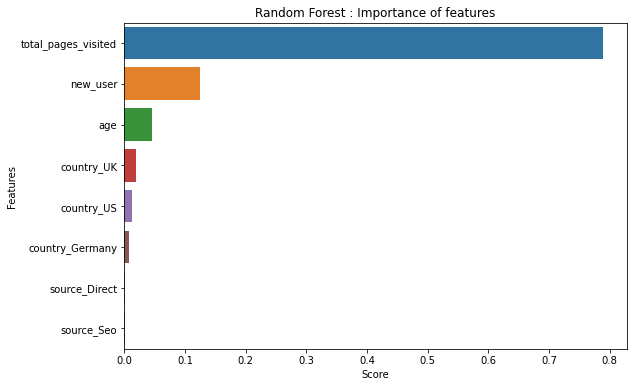

In [24]:
feature_importance_rand_forest = feature_importance_rand_forest.sort_values(by="Score", ascending=False)

plt.figure(figsize=(9,6))
sns.barplot(data=feature_importance_rand_forest, x="Score", y=feature_importance_rand_forest.index)
plt.ylabel("Features")
plt.title("Random Forest : Importance of features")
plt.show()

* In comparison with the tree decision model, we get here a greater importance of the variables __new_user__ and __age__ (the score of __new_user__ is beyond 0.1).
* Like the single-tree model, the variable counting the number of pages visited by the users remains very important compared to the other features (its score is far superior to 0.7).

## Searching for the best hyperparameters

Let us see if we can get better scores by optimising the hyperparameters.

### Logistic Regression

In [25]:
log_reg_estimator = LogisticRegression()
params = {'C' : [0.1, 0.5, 1, 5, 10, 20, 35, 50]}

log_reg_grid = GridSearchCV(estimator=log_reg_estimator, param_grid=params, cv=4, n_jobs=-1)
log_reg_grid.fit(X_train, y_train)
log_reg_grid.get_params()

{'cv': 4,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(),
 'iid': 'deprecated',
 'n_jobs': -1,
 'param_grid': {'C': [0.1, 0.5, 1, 5, 10, 20, 35, 50]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [26]:
log_reg_grid.best_params_

{'C': 0.5}

In [27]:
print("Best Logistic Regression score on training set : ", log_reg_grid.best_estimator_.score(X_train, y_train))
print("Best Logistic Regression score on test set : ", log_reg_grid.best_estimator_.score(X_test, y_test))

Best Logistic Regression score on training set :  0.9403113126608653
Best Logistic Regression score on test set :  0.9384803921568627


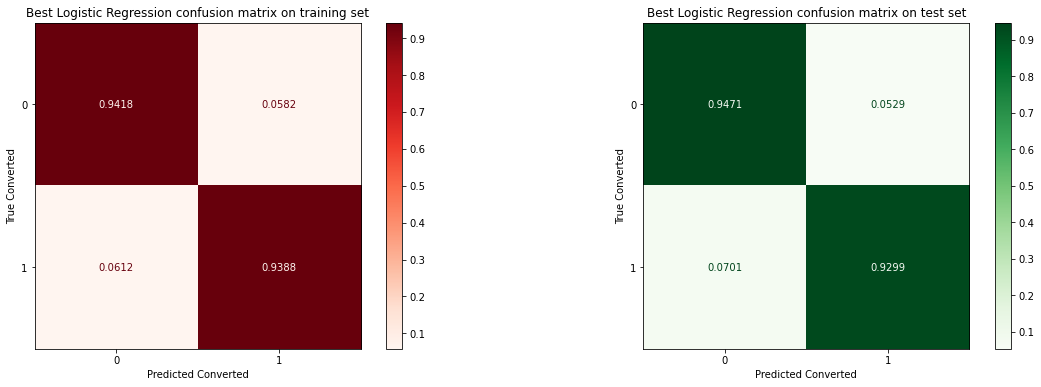

In [28]:
fig, axs = plt.subplots(figsize=(20,6), nrows=1, ncols=2)

plot_confusion_matrix(log_reg_grid, X_train, y_train, ax=axs[0], normalize='true', values_format='.4f', cmap=plt.cm.Reds)
axs[0].set_title("Best Logistic Regression confusion matrix on training set")
axs[0].set_xlabel("Predicted Converted")
axs[0].set_ylabel("True Converted")

plot_confusion_matrix(log_reg_grid, X_test, y_test, ax=axs[1], normalize='true', values_format='.4f', cmap=plt.cm.Greens)
axs[1].set_title("Best Logistic Regression confusion matrix on test set")
axs[1].set_xlabel("Predicted Converted")
axs[1].set_ylabel("True Converted")

plt.show()

In [29]:
print("Best Logistic Regression : classification metrics on training set")
print(classification_report(y_true=y_train, y_pred=log_reg_grid.best_estimator_.predict(X_train)))
print()
print("Best Logistic Regression : classification metrics on test set")
print(classification_report(y_true=y_test, y_pred=log_reg_grid.best_estimator_.predict(X_test)))

Best Logistic Regression : classification metrics on training set
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8160
           1       0.94      0.94      0.94      8158

    accuracy                           0.94     16318
   macro avg       0.94      0.94      0.94     16318
weighted avg       0.94      0.94      0.94     16318


Best Logistic Regression : classification metrics on test set
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2040
           1       0.95      0.93      0.94      2040

    accuracy                           0.94      4080
   macro avg       0.94      0.94      0.94      4080
weighted avg       0.94      0.94      0.94      4080



* In comparison with our logistic regression model, the results are extremely similar.
* For the record, the score on the training set was 0.940495 and the score on the test set was equal to 0.938725.

### Tree Decision or Random Forest

As we got a slight improvement of the results with the random forest, we will try to optimize the hyperparameters of this model.

In [30]:
random_forest_estimator = RandomForestClassifier()
params = {"n_estimators": range(20, 70, 10),
          "max_depth" : range(3, 11)
          }

rand_forest_grid = GridSearchCV(
    estimator = random_forest_estimator, 
    param_grid = params, 
    n_jobs=-1,
    cv=4
)

rand_forest_grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(3, 11),
                         'n_estimators': range(20, 70, 10)})

In [31]:
rand_forest_grid.best_params_

{'max_depth': 8, 'n_estimators': 50}

The random forest model applied earlier was composed of 50 estimators with the maximum depth set at 5.

In [32]:
print("Best Random Forest score on training set : ", rand_forest_grid.best_estimator_.score(X_train, y_train))
print("Best Random Forest score on test set : ", rand_forest_grid.best_estimator_.score(X_test, y_test))

Best Random Forest score on training set :  0.9442946439514647
Best Random Forest score on test set :  0.9370098039215686


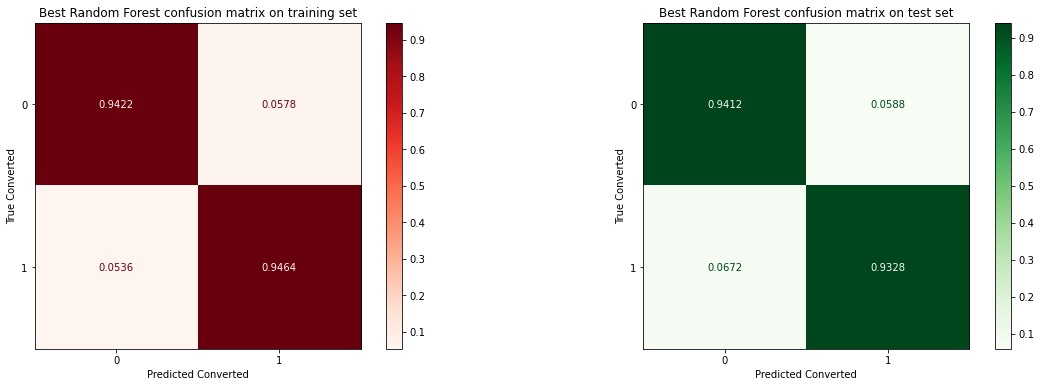

In [33]:
fig, axs = plt.subplots(figsize=(20,6), nrows=1, ncols=2)

plot_confusion_matrix(rand_forest_grid, X_train, y_train, ax=axs[0], normalize='true', values_format='.4f', cmap=plt.cm.Reds)
axs[0].set_title("Best Random Forest confusion matrix on training set")
axs[0].set_ylabel("True Converted")
axs[0].set_xlabel("Predicted Converted")

plot_confusion_matrix(rand_forest_grid, X_test, y_test, ax=axs[1], normalize='true', values_format='.4f', cmap=plt.cm.Greens)
axs[1].set_title("Best Random Forest confusion matrix on test set")
axs[1].set_ylabel("True Converted")
axs[1].set_xlabel("Predicted Converted")

plt.show()

In [34]:
print("Best Random Forest : classification metrics on training set")
print(classification_report(y_true=y_train, y_pred=rand_forest_grid.best_estimator_.predict(X_train)))
print()
print("Best Random Forest : classification metrics on test set")
print(classification_report(y_true=y_test, y_pred=rand_forest_grid.best_estimator_.predict(X_test)))

Best Random Forest : classification metrics on training set
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      8160
           1       0.94      0.95      0.94      8158

    accuracy                           0.94     16318
   macro avg       0.94      0.94      0.94     16318
weighted avg       0.94      0.94      0.94     16318


Best Random Forest : classification metrics on test set
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2040
           1       0.94      0.93      0.94      2040

    accuracy                           0.94      4080
   macro avg       0.94      0.94      0.94      4080
weighted avg       0.94      0.94      0.94      4080



* This new classifier get better results on the training set judging by the global score (0.9442 compared to 0.9335), the confusion matrix and the f1-score for the two classes (0.94 compared to 0.93).
* Nevertheless, on testing set, the change is less obvious if we look at the global score (0.9370 compared to 0.9306), and the confusion matrix : 
    * 93.82% of users from negative class were predicted correctly in the first model versus 94.12% with this model
    * 92.3% of users belonging to positive class had good predictions against 93.28% with the optimized model

## Comparison of the models

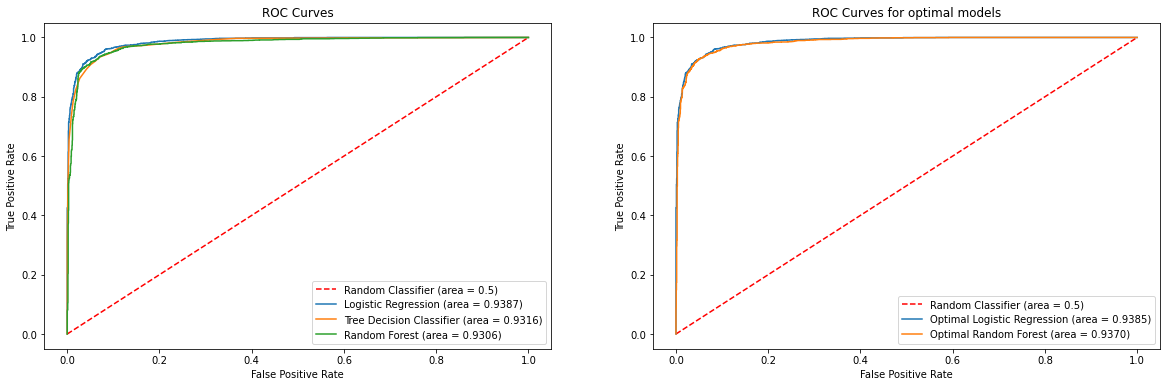

In [35]:
# Logistic Regression
log_reg_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])

# Tree Decision
tree_classifier_roc_auc = roc_auc_score(y_test, tree_classifier.predict(X_test))
fpr_tree_classif, tpr_tree_classif, thresholds = roc_curve(y_test, tree_classifier.predict_proba(X_test)[:,1])

# Random Forest
rand_forest_roc_auc = roc_auc_score(y_test, rand_forest.predict(X_test))
fpr_rand_forest, tpr_rand_forest, thresholds = roc_curve(y_test, rand_forest.predict_proba(X_test)[:,1])

# Optimised Logistic Regression
log_reg_grid_roc_auc = roc_auc_score(y_test, log_reg_grid.predict(X_test))
fpr_log_reg_grid, tpr_log_reg_grid, thresholds = roc_curve(y_test, log_reg_grid.predict_proba(X_test)[:,1])

# Optimised Random Forest
rand_forest_grid_roc_auc = roc_auc_score(y_test, rand_forest_grid.predict(X_test))
fpr_rand_forest_grid, tpr_rand_forest_grid, thresholds = roc_curve(y_test, rand_forest_grid.predict_proba(X_test)[:,1])

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.title('ROC Curves')
plt.plot([0, 1], [0, 1],'r--', label="Random Classifier (area = 0.5)" )
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % log_reg_roc_auc)
plt.plot(fpr_tree_classif, tpr_tree_classif, label='Tree Decision Classifier (area = %0.4f)' % tree_classifier_roc_auc)
plt.plot(fpr_rand_forest, tpr_rand_forest, label='Random Forest (area = %0.4f)' % rand_forest_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.subplot(122)
plt.title('ROC Curves for optimal models')
plt.plot([0, 1], [0, 1],'r--', label="Random Classifier (area = 0.5)" )
plt.plot(fpr, tpr, label='Optimal Logistic Regression (area = %0.4f)' % log_reg_grid_roc_auc)
plt.plot(fpr_rand_forest_grid, tpr_rand_forest_grid, label='Optimal Random Forest (area = %0.4f)' % rand_forest_grid_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.show()

In [36]:
model_comparison = pd.DataFrame(index=["Logistic Regression", "Tree Decision Classifier", "Random Forest", 
                                       "Optimal Logistic Regression", "Optimal Random Forest"])
model_comparison["Score"] = [log_reg.score(X_test, y_test), tree_classifier.score(X_test, y_test), 
                             rand_forest.score(X_test, y_test), log_reg_grid.score(X_test, y_test),
                             rand_forest_grid.score(X_test, y_test)]
model_comparison["Precision"] = [
    precision_score(y_test, log_reg.predict(X_test)),
    precision_score(y_test, tree_classifier.predict(X_test)),
    precision_score(y_test, rand_forest.predict(X_test)),
    precision_score(y_test, log_reg_grid.predict(X_test)),
    precision_score(y_test, rand_forest_grid.predict(X_test))
]
model_comparison["Recall"] = [
    recall_score(y_test, log_reg.predict(X_test)),
    recall_score(y_test, tree_classifier.predict(X_test)),
    recall_score(y_test, rand_forest.predict(X_test)),
    recall_score(y_test, log_reg_grid.predict(X_test)),
    recall_score(y_test, rand_forest_grid.predict(X_test))
]

In [37]:
model_comparison

,Score,Precision,Recall
Logistic Regression,0.938725,0.946162,0.930392
Tree Decision Classifier,0.931618,0.930984,0.932353
Random Forest,0.930637,0.937282,0.923039
Optimal Logistic Regression,0.938480,0.946135,0.929902
Optimal Random Forest,0.937010,0.940682,0.932843


In the light of the ROC curves, accuracy scores, precision scores and recall scores, the logistic regression model is the best. Therefore, it is this one that we will use to make predictions for the new Internet users who are going to consult the website. 

## Conclusion

* At the end of the Data Understanding section, we had identified the role that three pieces of information could play in a user's propensity to make a purchase :
    - the total number of pages visited
    - the age of the individual
    - whether it is a new user or a person who has visited the site before
* In the Machine Learning section, through the various trained models, our intuitions were confirmed by the analysis of the different results. We have seen above all the very great importance of the number of pages visited in decision making, then come in a lesser (but not negligible) extent the information about the first user's visit or not, then his age. 
* The selected model allows us to state that the more the number of pages visited increases, the bigger is the probability that the user makes a purchase. Elsewhere, to a lesser degree, if the user is consulting the website for the first time, or if the user is elderly  (the average age of users who convert is 25), they are less likely to make a purchase.
* We therefore recommend that the site maintenance team focus on features that not only drive the user to more pages, but also keep them coming back for more. Keeping up with the new trends that young people between the ages of 18 and 31 are following is also an avenue to pursue.